# Testing LSH reduction on MNIST

In [1]:
from LSH_reduction import * 
from resnet18_model import * 
import math
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import choices
import copy
import os
import subprocess
from torchvision import transforms
import torch.nn as nn
import csv
import copy

cos_sim = lambda a,b: np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [2]:
def confusion_matrix(rp, net, testloader):
    # prepare to count predictions for each class
    preds = np.zeros((rp.num_labels, rp.num_labels))
    total_pred = np.zeros(rp.num_labels)

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.cuda())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                preds[label][prediction] += 1
                total_pred[label.item()] += 1

    # print accuracy for each class
    return preds/total_pred[:,None]

In [3]:
def accuracy(rp, p, shrinkage = 'LSH'):
    global trainset
    global testset
    global net
    t0 = time.time()
    
    learning_rate = 0.001
    epochs = 7
    batch_size = 256
    
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    net = ResNet(img_channels = 1, num_layers = 18, block = BasicBlock, num_classes = len(rp.label_to_reps)+int(trainset.split == 'letters'))
    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    
    if p == 0:
        trainset_reduced = trainset
    elif shrinkage == 'LSH':
        ixs_shrinked = shrink(rp, p)
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
    else:
        full_data_size = rp.array.shape[0]
        ixs_shrinked = np.random.randint(low = 0, high = full_data_size, size = int(full_data_size*(1-p)))
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
        
    trainloader = torch.utils.data.DataLoader(trainset_reduced, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train(epoch, net, criterion, optimizer, trainloader, device=device)
        test_loss, test_acc = test(epoch, net, criterion, testloader, device=device)

    return (test_acc, time.time()-t0, confusion_matrix(rp, net, testloader))

In [4]:
# Downloading and getting an EMNIST dataset
split = 'digits' ## visit https://www.nist.gov/itl/products-and-services/emnist-dataset
                 ## to see more split options
trainset = torchvision.datasets.EMNIST(root='./data', train=True, 
                                       download=True, transform=transforms.ToTensor(), split = split)
testset = torchvision.datasets.EMNIST(root='./data', train=False, 
                                      download=True, transform=transforms.ToTensor(), split = split)

print("trainset len:", len(trainset))

trainset len: 240000


In [5]:
%%time
# Create instance of our rp class
rp = Random_projection_hash(trainset)
rp.hash_values()
rp.estimation()

Using: 9 bits, 3 hash tables
CPU times: user 35.7 s, sys: 2.06 s, total: 37.8 s
Wall time: 31.5 s


In [6]:
def get_results(rp, n_reps, max_p = 90, shrink_type = 'LSH'):
    acc_res = []
    time_res = []
    std_res = []
    
    print(f'\nResults for {shrink_type} shrinkage:')
    for p in range(int((max_p + 10)/10)):
        total_acc = 0
        total_time = 0
        total_conf = np.zeros((rp.num_labels, rp.num_labels))
        
        for _ in range(n_reps):
            acc, tm, conf = accuracy(rp, p/10, shrink_type)
            total_acc += acc
            total_time += tm
            total_conf += conf
        
        acc_res.append(total_acc/n_reps)
        time_res.append(total_time/n_reps)
        std_res.append(np.diagonal(total_conf/n_reps).std())
        print(f'p: {10*p}% {" "*(p==0)} |  acc: {acc_res[-1]:.4f}  | time: {time_res[-1]:.4f}  | std: {std_res[-1]:.4f}')

    return np.array(acc_res), np.array(time_res), np.array(std_res)

In [ ]:
n_reps = 6 # number of times each percentage will be tested
max_p = 90

## Save values for later plotting
acc_res_lsh, time_res_lsh, std_res_lsh = get_results(rp, n_reps, max_p, 'LSH')
acc_res_random, time_res_random, std_res_random = get_results(rp, n_reps, max_p, 'RND')


Results for LSH shrinkage:
p: 0%   |  acc: 99.4792  | time: 87.3665  | std: 0.0015
p: 10%  |  acc: 99.4800  | time: 84.2573  | std: 0.0013
p: 20%  |  acc: 99.4496  | time: 79.2677  | std: 0.0016


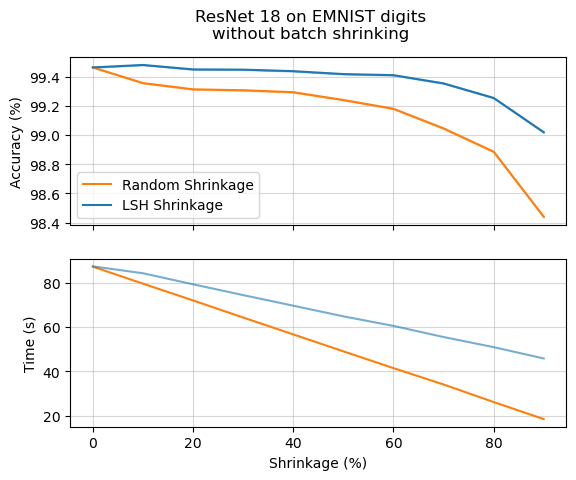

In [11]:
fig, ax = plt.subplots(2,1, sharex = True)
p = [10*i for i in range(int((max_p + 10)/10))]

a = 1/2*(acc_res_random[0] + acc_res_lsh[0])
acc_res_random[0] = a
acc_res_lsh[0] = a

ax[0].grid(alpha = 0.5)
ax[1].grid(alpha = 0.5)

ax[0].plot(p, acc_res_random, c = 'tab:orange', label = 'Random Shrinkage')
ax[0].fill_between(p, acc_res_random - std_res_random, acc_res_random + std_res_random, color = 'tab:orange', alpha = 0.4)
ax[0].plot(p, acc_res_lsh, c = 'tab:blue', label = 'LSH Shrinkage')
ax[0].fill_between(p, acc_res_lsh - std_res_lsh, acc_res_lsh + std_res_lsh, color = 'tab:blue', alpha = 0.4)
ax[0].set_ylabel('Accuracy (%)')

ax[1].plot(p, time_res_random, c = 'tab:orange')
ax[1].plot(p, time_res_lsh, c = 'tab:blue', alpha = 0.6)
ax[1].set_ylabel('Time (s)')

ax[0].legend()
ax[1].set_xlabel('Shrinkage (%)')
fig.suptitle(f'ResNet 18 on EMNIST {split}\nwithout batch shrinking')
plt.savefig('Resnet18_on_MNIST.png')

### Interpreting results

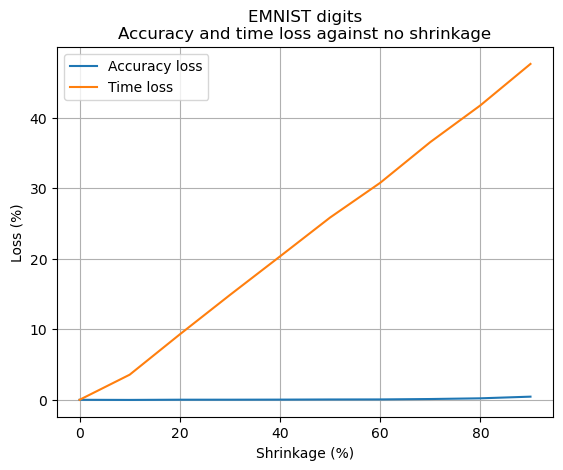

In [12]:
plt.plot(p, (1-acc_res_lsh/acc_res_lsh[0])*100, label = 'Accuracy loss')
plt.plot(p, (1-time_res_lsh/time_res_lsh[0])*100, label = 'Time loss')
plt.legend()
plt.grid()
plt.title(f'EMNIST {split}\nAccuracy and time loss against no shrinkage')
plt.xlabel('Shrinkage (%)')
_ = plt.ylabel('Loss (%)')

### Saving results

In [13]:
import pandas as pd
import re
df = pd.DataFrame([p, acc_res_lsh, acc_res_random, time_res_lsh, time_res_random, std_res_lsh, std_res_random]).T
df.rename(columns = {0:'shrinkage_p', 1:'lsh_acc', 2:'random_acc', 
                     3:'lsh_time', 4:'random_time', 5:'lsh_std', 6:'random_std'}, inplace = True)
df.set_index('shrinkage_p', inplace = True)
filepath = f'Results/EMNIST_{split}_wobs_results.csv'
df.to_csv(filepath)